In [1]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 7
n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'
pv_method = 'CL'

base_day = 30
prediction_day = base_day
slide = base_day

profit_percentage = 0.1
loss_percentage = 0.1

# Import packages


In [2]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

# Load data


In [3]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


# Data preprocessing


In [4]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [5]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [6]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [7]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # get harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [8]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            # for j in range(n_harm):
            for j in range(2, n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [9]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [10]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [11]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [12]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [13]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [14]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [15]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [16]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [17]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [18]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [19]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [20]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [21]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valleys'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valleys'


In [22]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data_copy[d].index = test_data[d]['index']
        test_data_copy[d] = test_data_copy[d].drop(test_data_copy[d][test_data_copy[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['Close'], 'gray', label='data', linewidth=3)
    for d in test_data_copy :
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy[d].index, test_data_copy[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [23]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    # return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [24]:
# main_funtion(
#     stock_name, date_predict_start, data_range, slide_range,
#         n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method)

# Lstm function

In [25]:
def preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide):
    x_train = {}
    y_train = {}
    for i in train_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaled_data = scaler.fit_transform(train_data[i]['Close'].values.reshape(-1,1))
        x_train[i] = []
        y_train[i] = []
        # for x in range(base_day+prediction_day, len(scaled_data), slide):
        for x in range(base_day+prediction_day, len(scaled_data)):
            x_train[i].append(scaled_data[x-base_day-prediction_day:x-prediction_day])
            y_train[i].append(scaled_data[x-prediction_day:x])
        x_train[i], y_train[i] = np.array(x_train[i]), np.array(y_train[i])
        # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
        x_train[i] = np.reshape(x_train[i], (x_train[i].shape[0], x_train[i].shape[1], 1))
        y_train[i] = np.reshape(y_train[i], (y_train[i].shape[0], y_train[i].shape[1], 1))
    return x_train, y_train

In [26]:
def LSTM_model(prediction_day, input_shape):
    model = Sequential()
    model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 128, return_sequences = True))
    model.add(Dropout(0.4))
    model.add(LSTM(units = 64))
    model.add(Dropout(0.4))
    model.add(Dense(units=prediction_day))
    return model

In [27]:
def build_Lstm_model(train_data, prediction_day, input_shape):
    model = {}
    for i in train_data:
        model[i] = LSTM_model(prediction_day, input_shape)
        model[i].compile(optimizer='adam', 
                    loss='mean_squared_error')
        # model[i].summary()
    return model

In [28]:
def train_Lstm_model(train_data, model, x_train, y_train):
    history = {}
    for i in tqdm(train_data):
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history[i] = model[i].fit(x_train[i], y_train[i], epochs=25, batch_size=32, 
                            callbacks = [earlystopper], validation_split = 0.2, shuffle=True)
    return history

In [29]:
def preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide):
    x_test = {}
    y_test = {}
    for i in test_data:
        scaler = MinMaxScaler(feature_range=(-1,1))
        model_inputs = pd.concat((train_data[i]['Close'].iloc[-base_day:], test_data[i]['Close'])).values
        model_inputs = model_inputs.reshape(-1,1)
        model_inputs = scaler.fit_transform(model_inputs)
        x_test[i] = []
        y_test[i] = []
        for x in range(base_day+prediction_day, len(model_inputs), slide):
            x_test[i].append(model_inputs[x-base_day-prediction_day:x-prediction_day])
            y_test[i].append(model_inputs[x-prediction_day:x])
        x_test[i], y_test[i] = np.array(x_test[i]), np.array(y_test[i])
        x_test[i] = np.reshape(x_test[i], (x_test[i].shape[0], x_test[i].shape[1], 1))
        y_test[i] = np.reshape(y_test[i], (y_test[i].shape[0], y_test[i].shape[1], 1))
    return x_test, y_test

In [30]:
def predicting_creat_processed_signal_Lstm(x_test, test_data, model):
    processed_signal = {}
    for i in test_data:
        predicted_prices = model[i].predict(x_test[i])
        processed_signal[i] = {}
        processed_signal[i][0] = pd.DataFrame(
            {'Close': predicted_prices.flatten()}, index=test_data[i].index[:len(predicted_prices.flatten())])
    return processed_signal

In [31]:
def result_table_process_Lstm_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[int(all_data.index.get_loc(result_table.loc[i, 's_date'])) + first_date[i]].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [32]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)
x_train, y_train = preprocessing_train_data_Lstm(train_data, base_day, prediction_day, slide)
x_test, y_test = preprocessing_test_data_Lstm(train_data, test_data, base_day, prediction_day, slide)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
5/5 [==============================] - 35s 3s/step - loss: 0.0405 - val_loss: 0.2216
Epoch 2/25
5/5 [==============================] - 1s 259ms/step - loss: 0.0345 - val_loss: 0.2013
Epoch 3/25
5/5 [==============================] - 1s 261ms/step - loss: 0.0329 - val_loss: 0.1964
Epoch 4/25
5/5 [==============================] - 2s 365ms/step - loss: 0.0312 - val_loss: 0.1903
Epoch 5/25
5/5 [==============================] - 2s 386ms/step - loss: 0.0299 - val_loss: 0.2168
Epoch 6/25
5/5 [==============================] - 1s 255ms/step - loss: 0.0286 - val_loss: 0.2383
Epoch 7/25
5/5 [==============================] - 1s 217ms/step - loss: 0.0288 - val_loss: 0.1932
Epoch 8/25
5/5 [==============================] - 1s 246ms/step - loss: 0.0277 - val_loss: 0.2077
Epoch 9/25
5/5 [==============================] - 1s 274ms/step - loss: 0.0272 - val_loss: 0.2021
Epoch 9: early stopping


 10%|█         | 1/10 [00:46<06:57, 46.34s/it]

Epoch 1/25
5/5 [==============================] - 33s 3s/step - loss: 0.0501 - val_loss: 0.2689
Epoch 2/25
5/5 [==============================] - 2s 316ms/step - loss: 0.0433 - val_loss: 0.2651
Epoch 3/25
5/5 [==============================] - 1s 296ms/step - loss: 0.0429 - val_loss: 0.2681
Epoch 4/25
5/5 [==============================] - 1s 317ms/step - loss: 0.0415 - val_loss: 0.2747
Epoch 5/25
5/5 [==============================] - 2s 321ms/step - loss: 0.0395 - val_loss: 0.2603
Epoch 6/25
5/5 [==============================] - 1s 281ms/step - loss: 0.0395 - val_loss: 0.2469
Epoch 7/25
5/5 [==============================] - 2s 307ms/step - loss: 0.0394 - val_loss: 0.2660
Epoch 8/25
5/5 [==============================] - 1s 298ms/step - loss: 0.0378 - val_loss: 0.2636
Epoch 9/25
5/5 [==============================] - 1s 269ms/step - loss: 0.0368 - val_loss: 0.2483
Epoch 10/25
5/5 [==============================] - 1s 264ms/step - loss: 0.0358 - val_loss: 0.2474
Epoch 11/25
5/5 [====

 20%|██        | 2/10 [01:40<06:47, 50.96s/it]

Epoch 1/25
5/5 [==============================] - 26s 2s/step - loss: 0.0986 - val_loss: 0.2935
Epoch 2/25
5/5 [==============================] - 1s 260ms/step - loss: 0.0783 - val_loss: 0.2829
Epoch 3/25
5/5 [==============================] - 1s 252ms/step - loss: 0.0685 - val_loss: 0.2925
Epoch 4/25
5/5 [==============================] - 1s 248ms/step - loss: 0.0637 - val_loss: 0.2810
Epoch 5/25
5/5 [==============================] - 1s 249ms/step - loss: 0.0636 - val_loss: 0.2920
Epoch 6/25
5/5 [==============================] - 1s 251ms/step - loss: 0.0609 - val_loss: 0.2775
Epoch 7/25
5/5 [==============================] - 1s 280ms/step - loss: 0.0590 - val_loss: 0.2879
Epoch 8/25
5/5 [==============================] - 1s 251ms/step - loss: 0.0546 - val_loss: 0.2764
Epoch 9/25
5/5 [==============================] - 1s 221ms/step - loss: 0.0560 - val_loss: 0.2406
Epoch 10/25
5/5 [==============================] - 1s 198ms/step - loss: 0.0572 - val_loss: 0.2898
Epoch 11/25
5/5 [====

 30%|███       | 3/10 [02:33<06:01, 51.67s/it]

Epoch 1/25
5/5 [==============================] - 25s 1s/step - loss: 0.1557 - val_loss: 0.2913
Epoch 2/25
5/5 [==============================] - 1s 248ms/step - loss: 0.1027 - val_loss: 0.2741
Epoch 3/25
5/5 [==============================] - 1s 246ms/step - loss: 0.0849 - val_loss: 0.2587
Epoch 4/25
5/5 [==============================] - 1s 239ms/step - loss: 0.0797 - val_loss: 0.2444
Epoch 5/25
5/5 [==============================] - 1s 245ms/step - loss: 0.0751 - val_loss: 0.2369
Epoch 6/25
5/5 [==============================] - 1s 249ms/step - loss: 0.0774 - val_loss: 0.2250
Epoch 7/25
5/5 [==============================] - 1s 266ms/step - loss: 0.0754 - val_loss: 0.2128
Epoch 8/25
5/5 [==============================] - 1s 277ms/step - loss: 0.0713 - val_loss: 0.1810
Epoch 9/25
5/5 [==============================] - 1s 254ms/step - loss: 0.0682 - val_loss: 0.1700
Epoch 10/25
5/5 [==============================] - 1s 252ms/step - loss: 0.0678 - val_loss: 0.1487
Epoch 11/25
5/5 [====

 40%|████      | 4/10 [03:17<04:53, 48.99s/it]

Epoch 1/25
5/5 [==============================] - 20s 830ms/step - loss: 0.1472 - val_loss: 0.3588
Epoch 2/25
5/5 [==============================] - 1s 218ms/step - loss: 0.1083 - val_loss: 0.3378
Epoch 3/25
5/5 [==============================] - 1s 239ms/step - loss: 0.0995 - val_loss: 0.3120
Epoch 4/25
5/5 [==============================] - 1s 233ms/step - loss: 0.0922 - val_loss: 0.2903
Epoch 5/25
5/5 [==============================] - 1s 235ms/step - loss: 0.0836 - val_loss: 0.2531
Epoch 6/25
5/5 [==============================] - 1s 240ms/step - loss: 0.0829 - val_loss: 0.2230
Epoch 7/25
5/5 [==============================] - 1s 263ms/step - loss: 0.0797 - val_loss: 0.1717
Epoch 8/25
5/5 [==============================] - 1s 282ms/step - loss: 0.0787 - val_loss: 0.1343
Epoch 9/25
5/5 [==============================] - 1s 245ms/step - loss: 0.0770 - val_loss: 0.1328
Epoch 10/25
5/5 [==============================] - 1s 262ms/step - loss: 0.0729 - val_loss: 0.0683
Epoch 11/25
5/5 [=

 50%|█████     | 5/10 [03:55<03:44, 44.84s/it]

Epoch 1/25
5/5 [==============================] - 22s 1s/step - loss: 0.0625 - val_loss: 0.3024
Epoch 2/25
5/5 [==============================] - 1s 242ms/step - loss: 0.0486 - val_loss: 0.1936
Epoch 3/25
5/5 [==============================] - 1s 236ms/step - loss: 0.0421 - val_loss: 0.1085
Epoch 4/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0396 - val_loss: 0.1224
Epoch 5/25
5/5 [==============================] - 1s 222ms/step - loss: 0.0388 - val_loss: 0.1223
Epoch 6/25
5/5 [==============================] - 1s 197ms/step - loss: 0.0359 - val_loss: 0.1136
Epoch 7/25
5/5 [==============================] - 1s 193ms/step - loss: 0.0340 - val_loss: 0.1876
Epoch 8/25
5/5 [==============================] - 1s 191ms/step - loss: 0.0340 - val_loss: 0.1432
Epoch 8: early stopping


 60%|██████    | 6/10 [04:24<02:38, 39.60s/it]

Epoch 1/25
5/5 [==============================] - 18s 1s/step - loss: 0.1352 - val_loss: 0.3381
Epoch 2/25
5/5 [==============================] - 1s 242ms/step - loss: 0.0900 - val_loss: 0.3240
Epoch 3/25
5/5 [==============================] - 1s 239ms/step - loss: 0.0683 - val_loss: 0.2235
Epoch 4/25
5/5 [==============================] - 1s 187ms/step - loss: 0.0584 - val_loss: 0.2519
Epoch 5/25
5/5 [==============================] - 1s 203ms/step - loss: 0.0520 - val_loss: 0.2187
Epoch 6/25
5/5 [==============================] - 1s 207ms/step - loss: 0.0453 - val_loss: 0.2182
Epoch 7/25
5/5 [==============================] - 1s 180ms/step - loss: 0.0405 - val_loss: 0.2225
Epoch 8/25
5/5 [==============================] - 1s 186ms/step - loss: 0.0374 - val_loss: 0.2245
Epoch 9/25
5/5 [==============================] - 1s 190ms/step - loss: 0.0349 - val_loss: 0.2381
Epoch 10/25
5/5 [==============================] - 1s 208ms/step - loss: 0.0345 - val_loss: 0.2534
Epoch 11/25
5/5 [====

 70%|███████   | 7/10 [04:52<01:47, 35.81s/it]

Epoch 1/25
5/5 [==============================] - 15s 1s/step - loss: 0.1722 - val_loss: 0.4795
Epoch 2/25
5/5 [==============================] - 1s 165ms/step - loss: 0.0987 - val_loss: 0.4116
Epoch 3/25
5/5 [==============================] - 1s 169ms/step - loss: 0.0703 - val_loss: 0.4305
Epoch 4/25
5/5 [==============================] - 1s 169ms/step - loss: 0.0575 - val_loss: 0.4906
Epoch 5/25
5/5 [==============================] - 1s 158ms/step - loss: 0.0476 - val_loss: 0.4998
Epoch 6/25
5/5 [==============================] - 1s 169ms/step - loss: 0.0425 - val_loss: 0.6081
Epoch 7/25
5/5 [==============================] - 1s 156ms/step - loss: 0.0399 - val_loss: 0.6118
Epoch 7: early stopping


 80%|████████  | 8/10 [05:12<01:01, 30.78s/it]

Epoch 1/25
5/5 [==============================] - 10s 704ms/step - loss: 0.2061 - val_loss: 0.7169
Epoch 2/25
5/5 [==============================] - 1s 147ms/step - loss: 0.1168 - val_loss: 0.5205
Epoch 3/25
5/5 [==============================] - 1s 147ms/step - loss: 0.0839 - val_loss: 0.7145
Epoch 4/25
5/5 [==============================] - 1s 147ms/step - loss: 0.0686 - val_loss: 0.6756
Epoch 5/25
5/5 [==============================] - 1s 143ms/step - loss: 0.0562 - val_loss: 0.8417
Epoch 6/25
5/5 [==============================] - 1s 152ms/step - loss: 0.0523 - val_loss: 0.8725
Epoch 7/25
5/5 [==============================] - 1s 147ms/step - loss: 0.0475 - val_loss: 0.8551
Epoch 7: early stopping


 90%|█████████ | 9/10 [05:27<00:25, 25.67s/it]

Epoch 1/25
5/5 [==============================] - 10s 628ms/step - loss: 0.2376 - val_loss: 0.6204
Epoch 2/25
5/5 [==============================] - 1s 162ms/step - loss: 0.1238 - val_loss: 0.5991
Epoch 3/25
5/5 [==============================] - 1s 157ms/step - loss: 0.0954 - val_loss: 0.6695
Epoch 4/25
5/5 [==============================] - 1s 150ms/step - loss: 0.0816 - val_loss: 0.9208
Epoch 5/25
5/5 [==============================] - 1s 152ms/step - loss: 0.0683 - val_loss: 0.7797
Epoch 6/25
5/5 [==============================] - 1s 148ms/step - loss: 0.0670 - val_loss: 0.8934
Epoch 7/25
5/5 [==============================] - 1s 149ms/step - loss: 0.0606 - val_loss: 0.8922
Epoch 7: early stopping


100%|██████████| 10/10 [05:41<00:00, 34.16s/it]


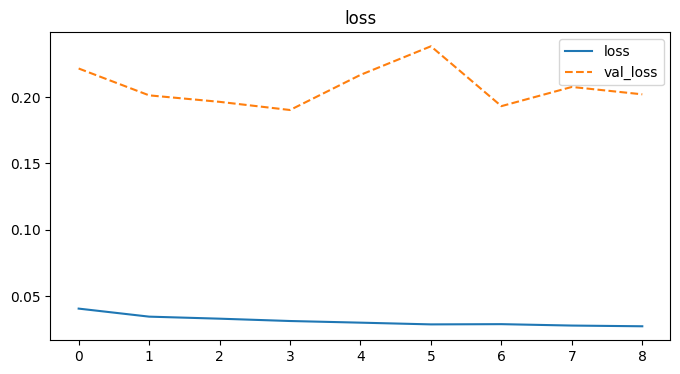

In [33]:
# 3. Build model
# harmonics, model = build_model(
    # train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
# harmonics = data_to_harmonics_function(train_data, data_range)
# processed_signal_FFT = mix_harmonics_function(
#     harmonics, n_harm_lower_limit, n_harm_upper_limit)
# processed_signal = processed_signal_FFT

input_shape = (x_train[list(x_train.keys())[0]].shape[1],1)
model = build_Lstm_model(train_data, prediction_day, input_shape)

history = train_Lstm_model(train_data, model, x_train, y_train)
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history['data_0'].history['loss'], label='loss')
plt.plot(history['data_0'].history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()


In [34]:
processed_signal = predicting_creat_processed_signal_Lstm(x_test, test_data, model)
find_signal_pv_function(processed_signal, pv_range)
find_signal_lead_train_function(train_data, processed_signal)

1/1 [==============================] - 2s 2s/step


In [35]:
# 4. Select model
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
#                                                                         model, fit_method)
errors = get_fit_error_function(processed_signal, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    processed_signal, errors)
find_signal_lead_test_function(test_data, processed_signal)
first_date, lead, pv = get_first_lead_function(
    processed_signal, best_fit_harm)


In [36]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_Lstm_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)

final_error =  9.0
            s_date      t_date  lead    ans_date      pv  error best_fit
data_0  2020-01-02  2020-01-22   7.0  2020-01-31  valley   8.89        0
data_1  2020-01-16  2020-02-03  -1.0  2020-01-31  valley  10.15        0
data_2  2020-01-31  2020-02-14 -10.0  2020-01-31  valley   9.98        0
data_3  2020-02-14  2020-02-18  24.0  2020-03-23  valley  10.54        0
data_4  2020-03-02  2020-03-03   1.0  2020-03-04    peak  11.61        0
data_5  2020-03-16  2020-03-19   2.0  2020-03-23  valley   8.77        0
data_6  2020-03-30  2020-04-02  18.0  2020-04-29    peak  10.44        0
data_7  2020-04-14  2020-04-23  -2.0  2020-04-21  valley   9.83        0
data_8  2020-04-28  2020-05-07  21.0  2020-06-08    peak  10.78        0
data_9  2020-05-12  2020-05-19  -4.0  2020-05-13  valley  10.74        0


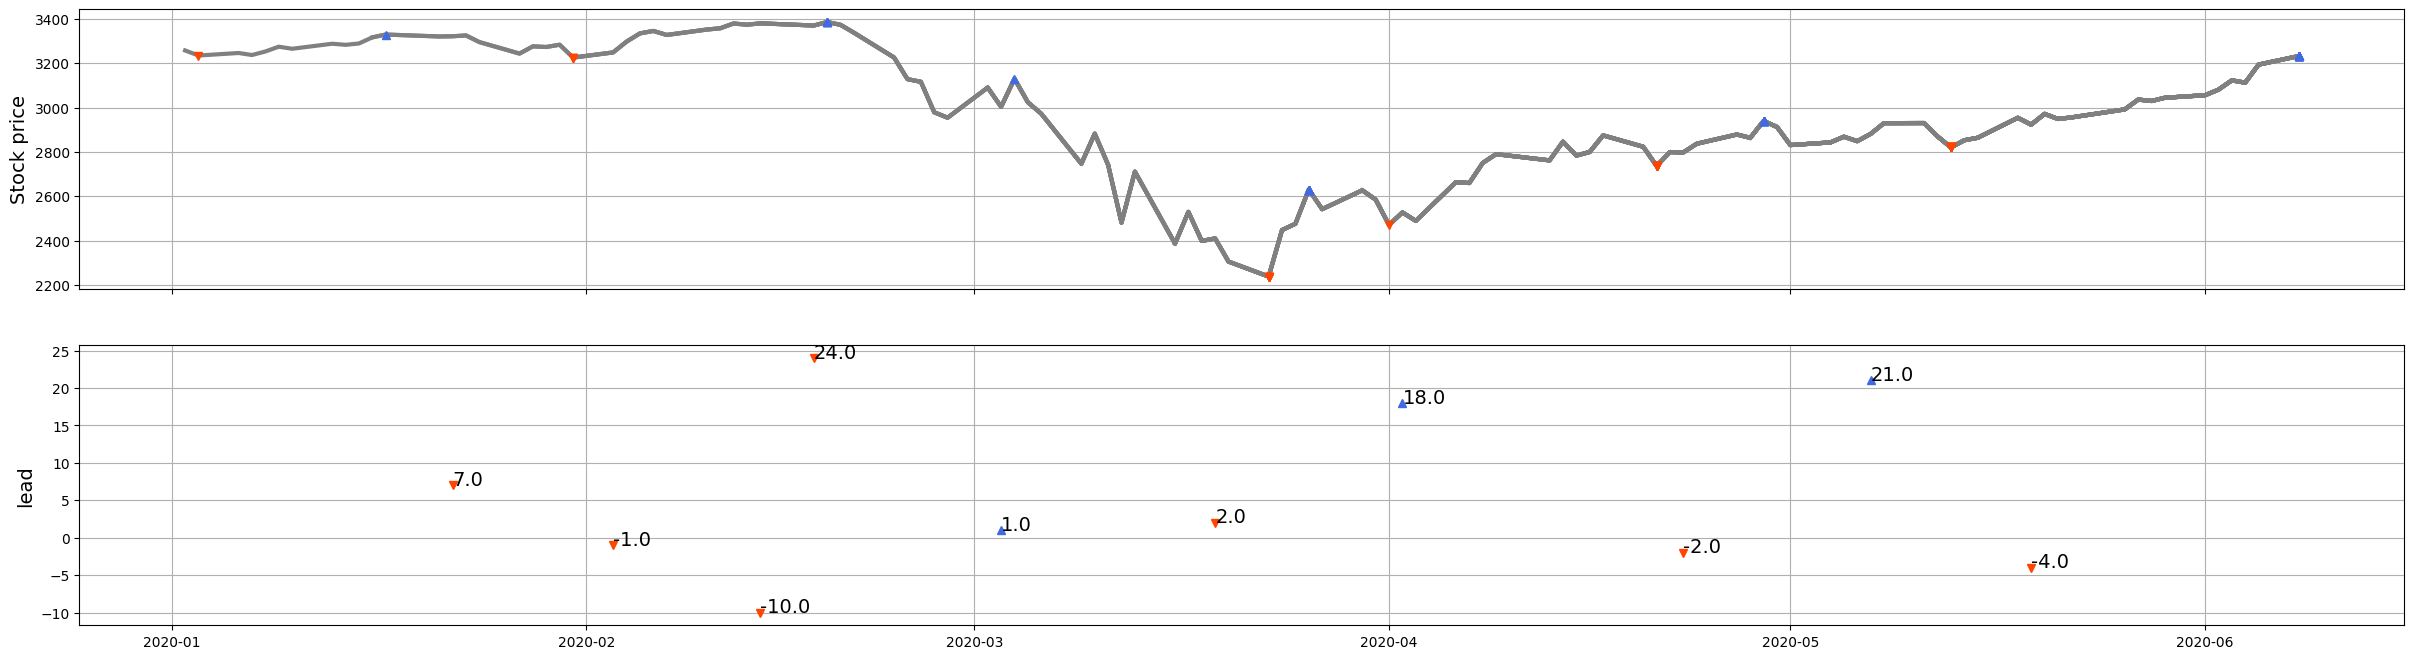

In [37]:
draw_plot_result_table(test_data, all_data, result_table, pv_range)

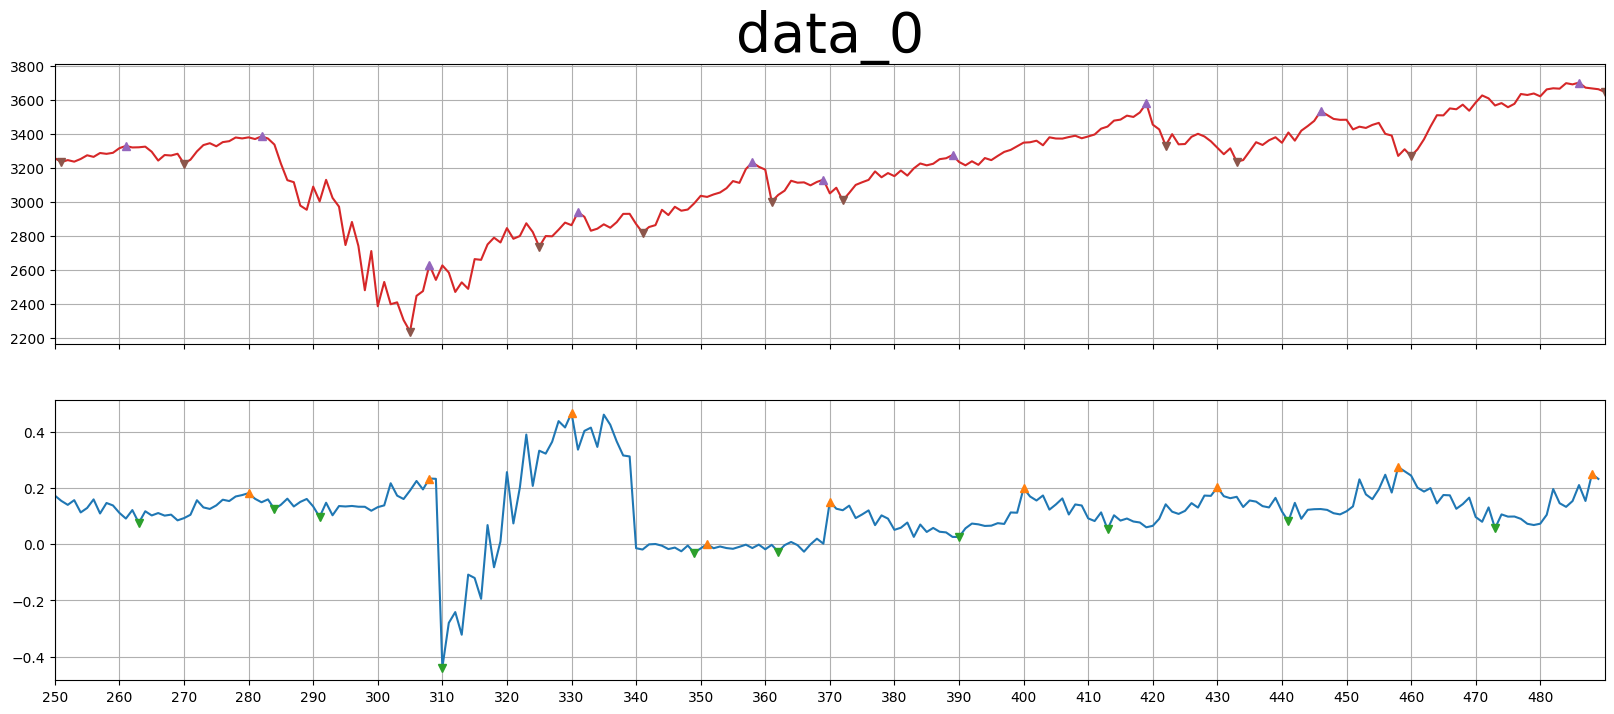

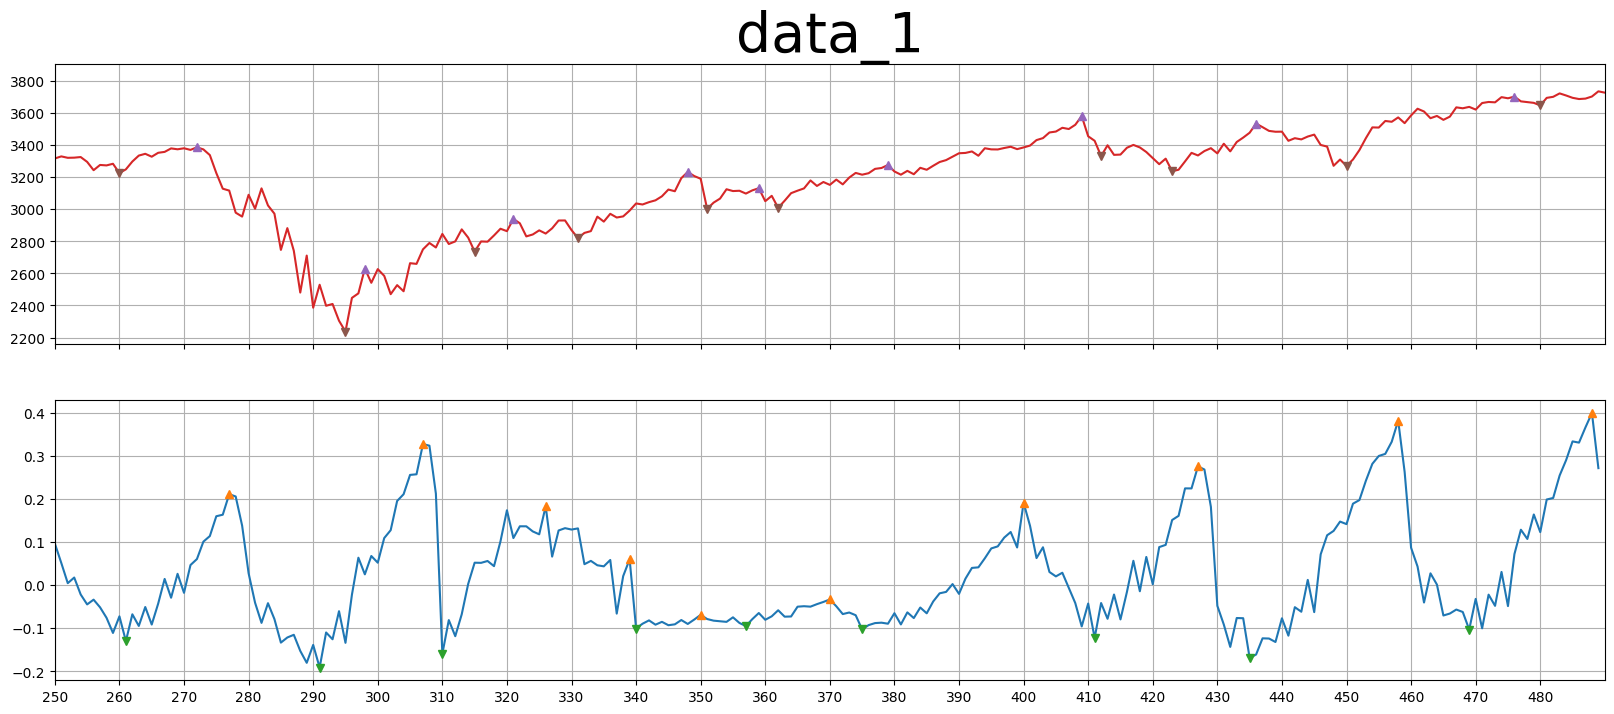

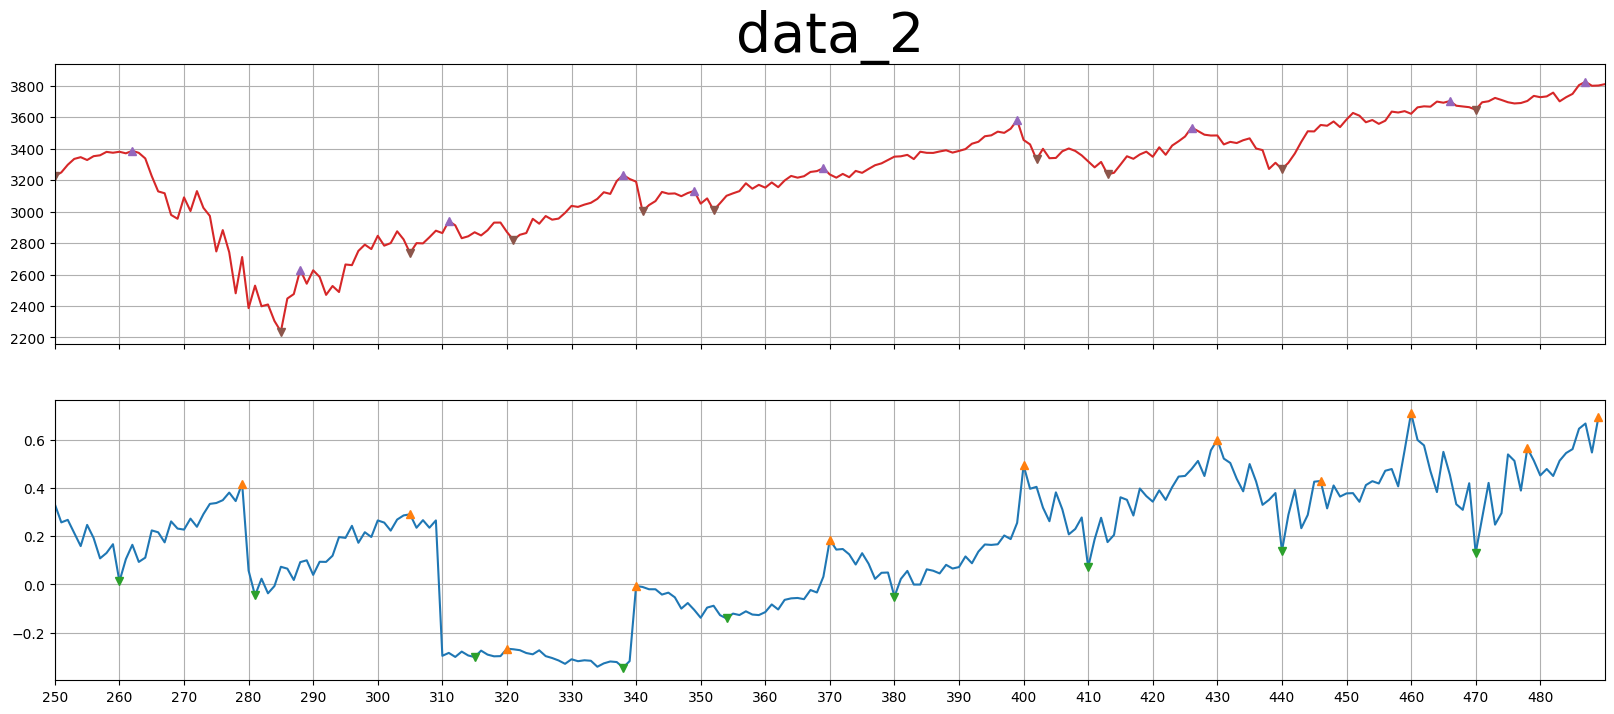

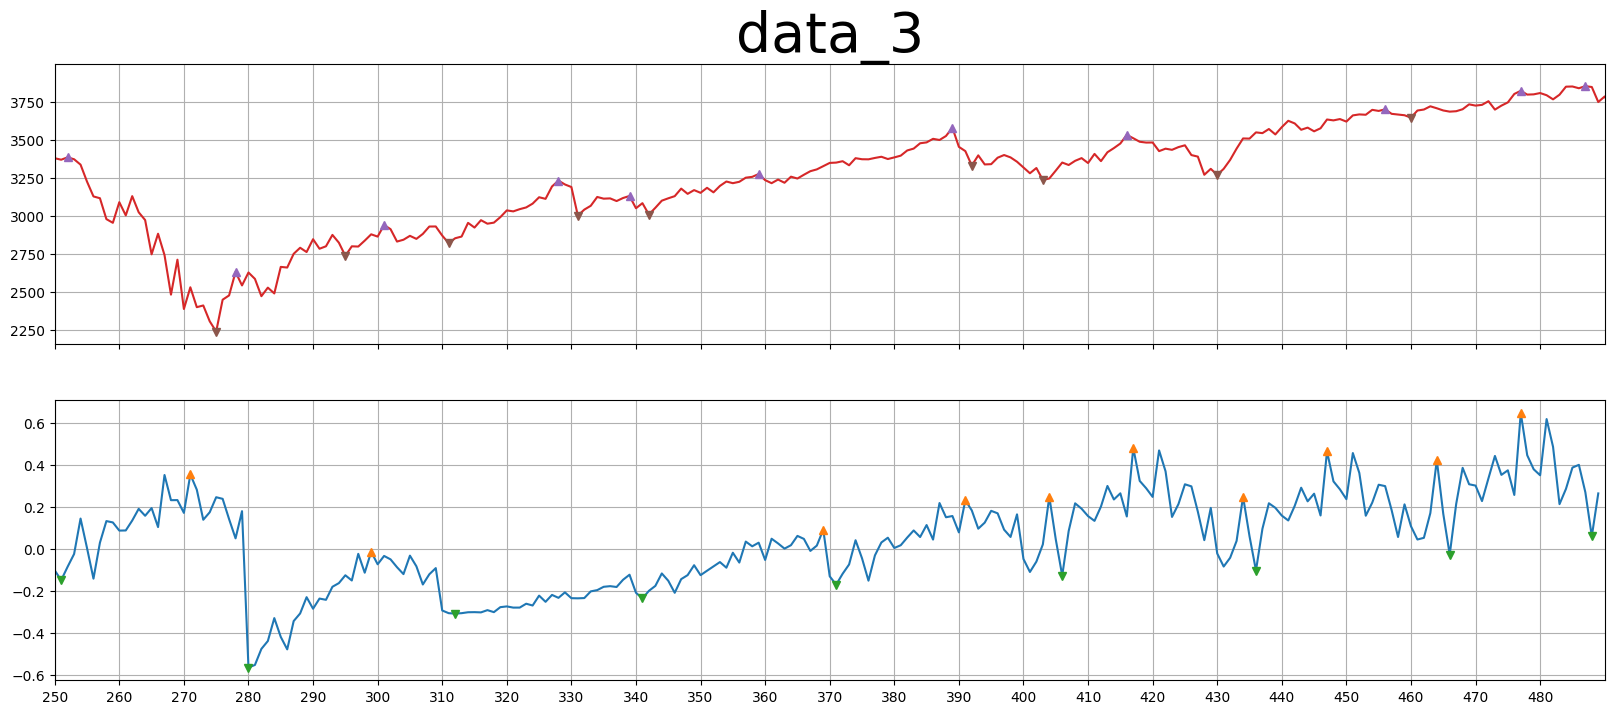

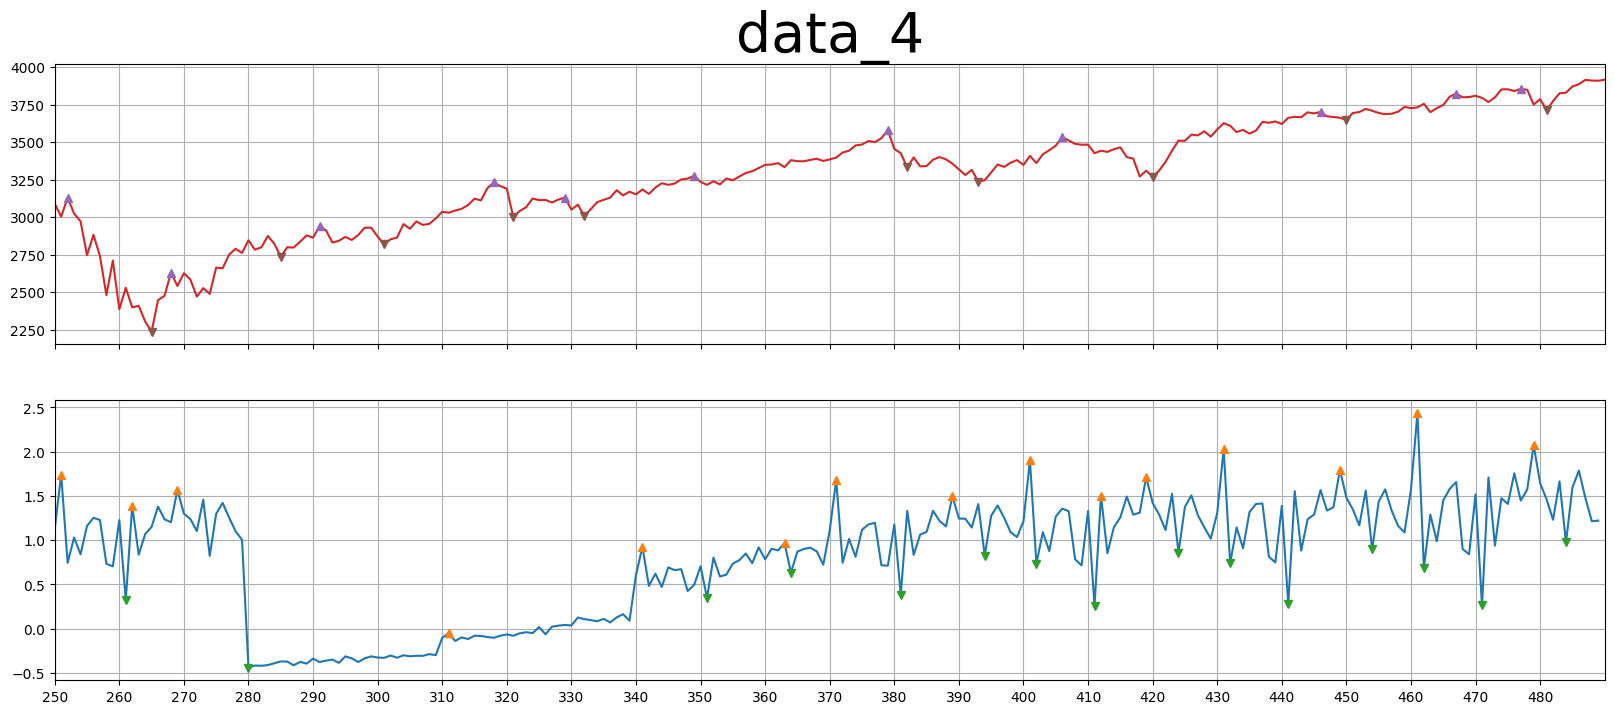

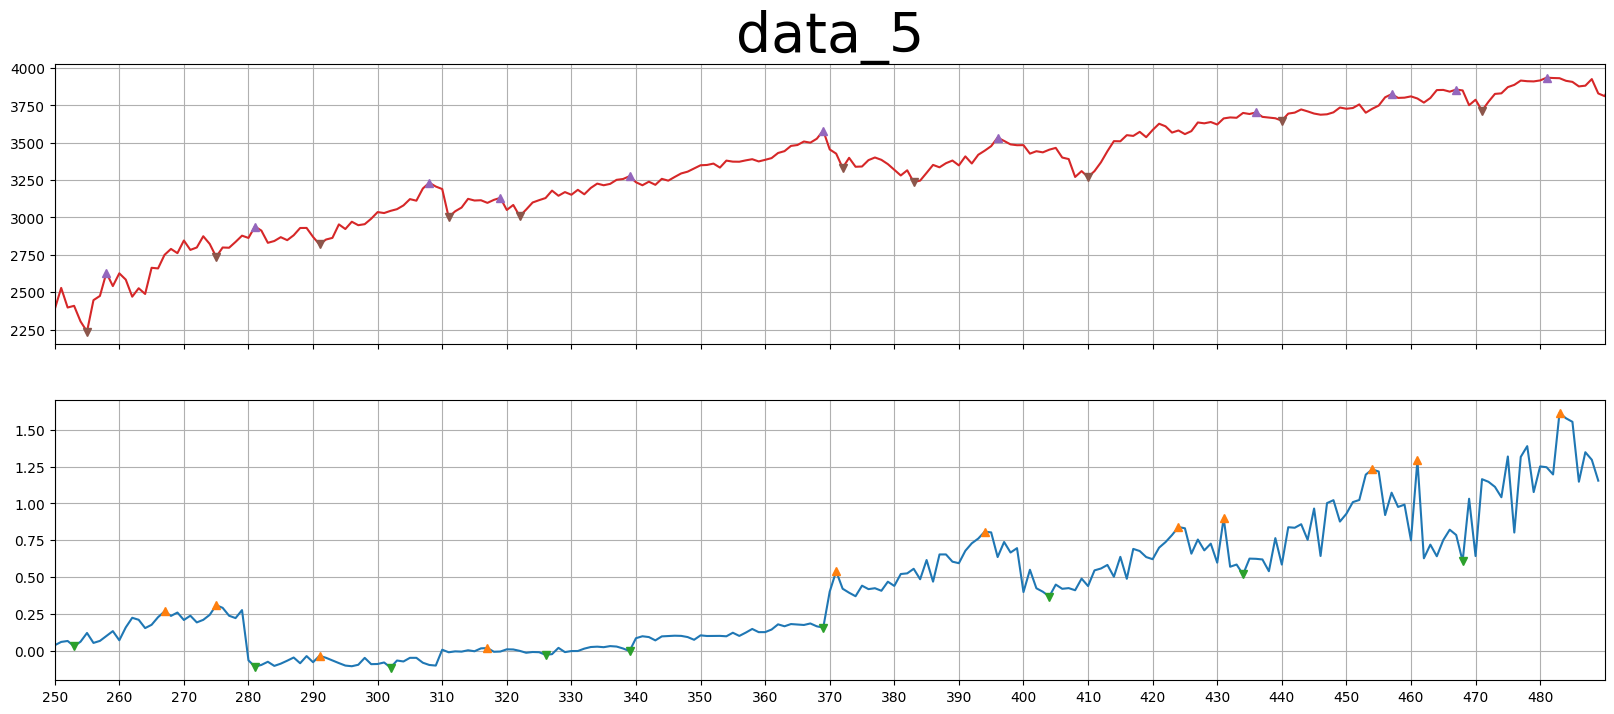

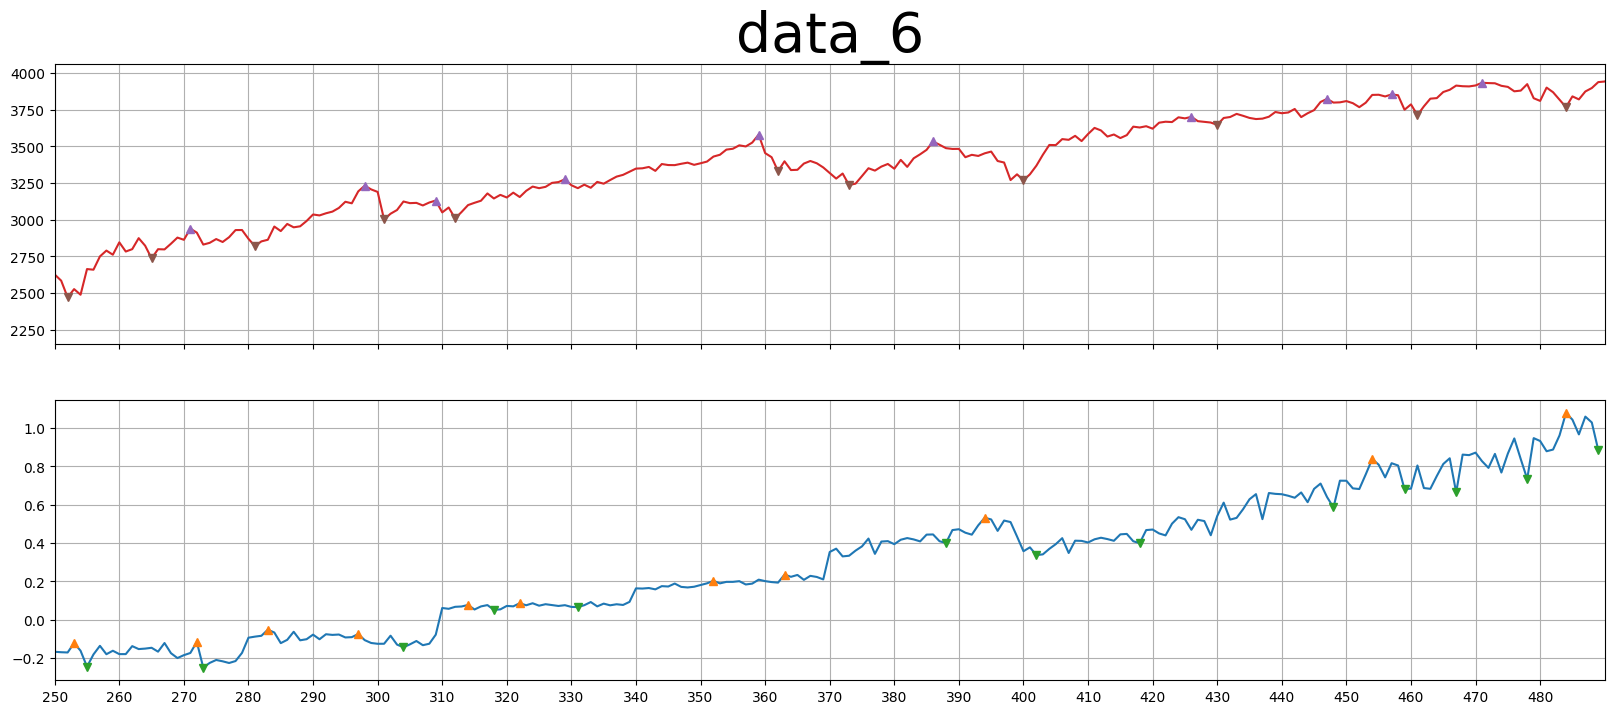

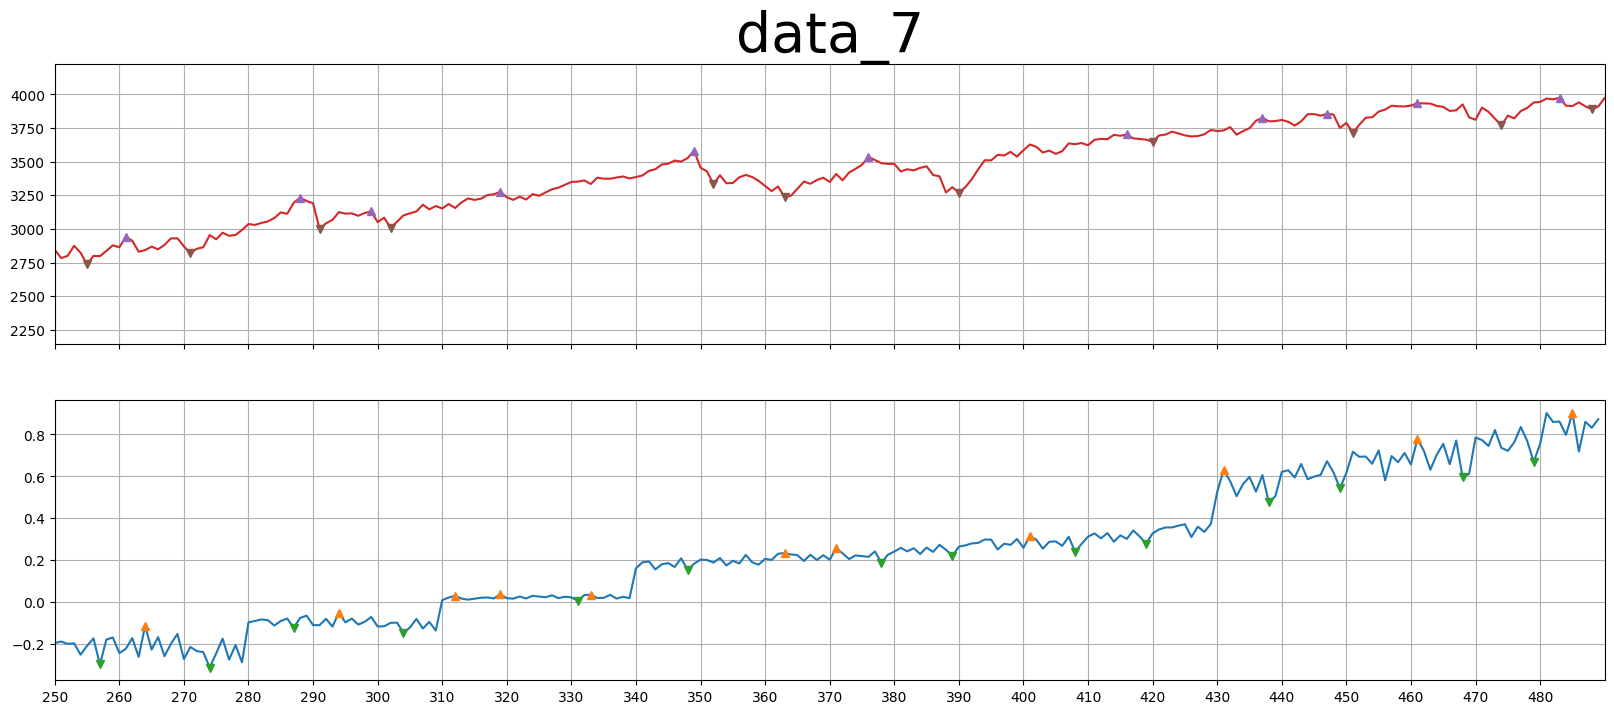

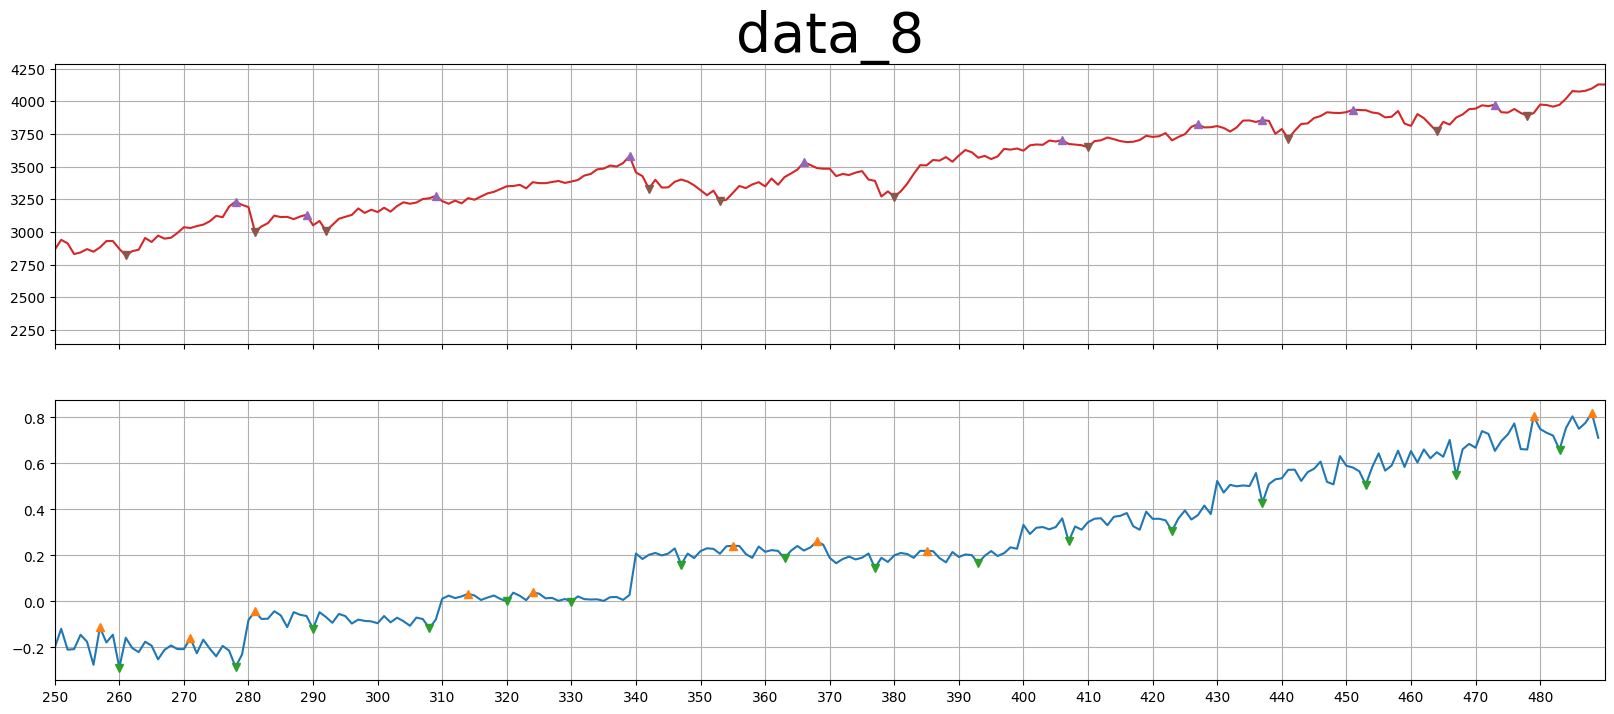

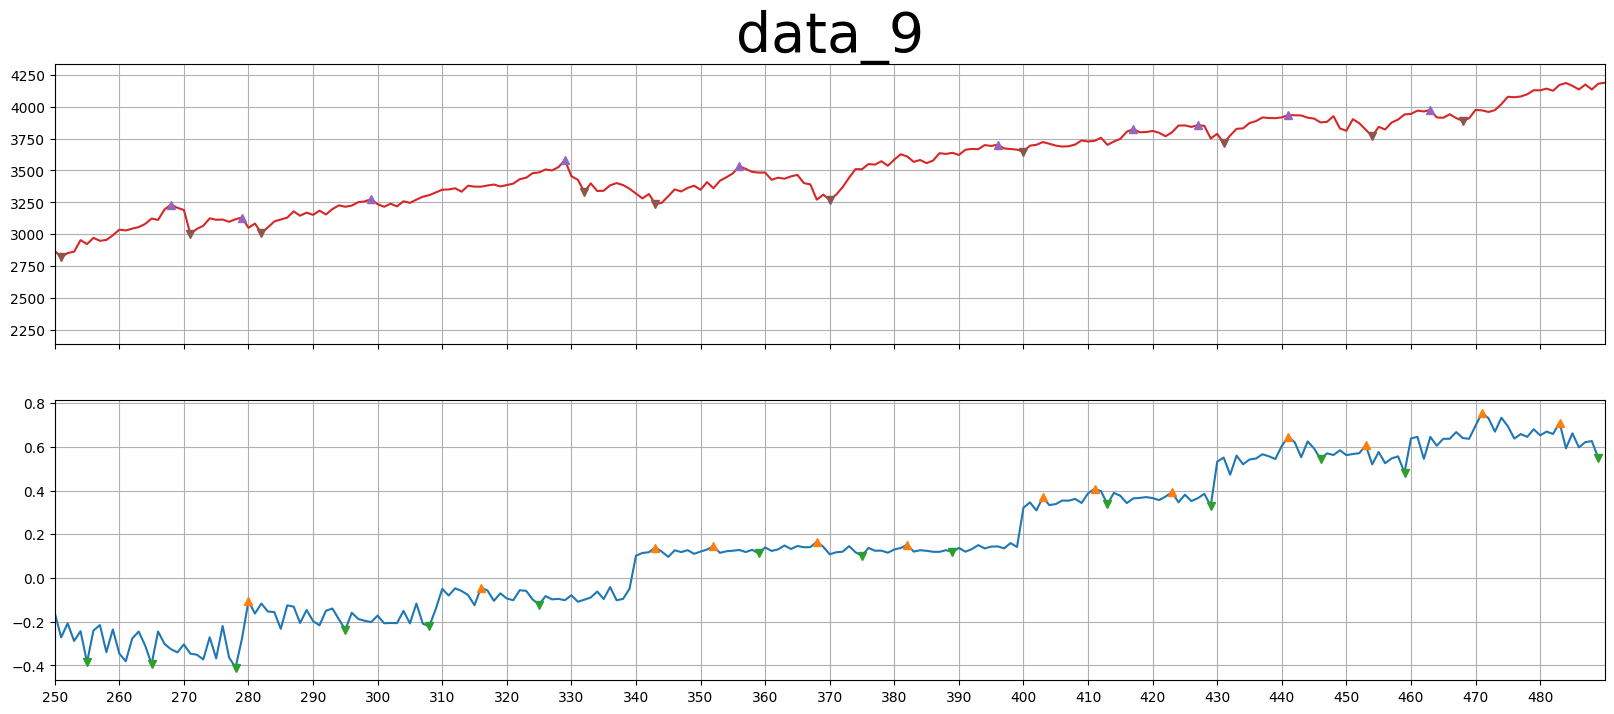

In [38]:
for i in processed_signal:
    fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
    axes[0].set_title(i, fontsize=40)
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['Close'])
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['peaks'], '^')
    axes[0].plot(range(0, len(train_data[i])), train_data[i]['valleys'], 'v')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['Close'])
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['peaks'], '^')
    axes[0].plot(range(len(train_data[i]), len(test_data[i])+len(train_data[i])), test_data[i]['valleys'], 'v')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['Close'])
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['peaks'], '^')
    axes[1].plot(range(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]])), processed_signal[i][best_fit_harm[i]]['valleys'], 'v')
    plt.xlim(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]))
    axes[0].grid()
    axes[1].grid()
    plt.xticks(np.arange(len(train_data[i]), len(train_data[i])+len(processed_signal[i][best_fit_harm[i]]), step=10))
    plt.show()

In [39]:
def kbar(open, close, high, low, pos):
    if close > open:             # 上漲
        color='red'                 # 紅 K 棒
        height=close - open   # 高度=收盤-開盤
        bottom=open             # 底部=開盤
    else:                               # 下跌
        color='green'              # 綠 k 棒
        height=open - close   # 高度=開盤-收盤
        bottom=close             # 底部=收盤
    # 繪製 k 棒實體      
    plt.bar(pos, height=height,bottom=bottom, width=1, color=color)
    # 繪製 k 棒上下影線
    plt.vlines(pos, high, low, color=color)

In [40]:
def draw_profit_plot(profit_table, pv_range):
    date_list = sorted(
        list(profit_table['in_date']) + list(profit_table['out_date']))
    plot_data = all_data.loc[date_list[0]:date_list[-1]]
    find_data_pv_function(plot_data, pv_range)
    plt.figure(figsize=(20, 8))
    for i in plot_data.index:
        kbar(plot_data['Open'].loc[i], plot_data['Close'].loc[i], plot_data['High'].loc[i], plot_data['Low'].loc[i], i)
    # plt.plot(plot_data['peaks'], '^', label='peaks', c='royalblue')
    # plt.plot(plot_data['valleys'], 'v', label='valleys', c='orangered')
    for i in profit_table.index:
        if profit_table.loc[i, 'pv'] == 'peak':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='green', arrowstyle='simple'))

        elif profit_table.loc[i, 'pv'] == 'valley':
            plt.annotate('', xy=(profit_table.loc[i, 'out_date'], profit_table.loc[i, 'out_price']),
                            xytext=(profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']),
                            arrowprops=dict(facecolor='red', arrowstyle='simple'))
        if 'strategy' in profit_table.columns:
            if profit_table.loc[i, 'strategy'] == 'stop_profit':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='red')
            elif profit_table.loc[i, 'strategy'] == 'stop_loss':
                plt.hlines(profit_table.loc[i, 'strategy_price'], profit_table.loc[i, 'in_date'], profit_table.loc[i, 'out_date'], color='green')
            
        # plt.annotate(f'{i}', (profit_table.loc[i, 'in_date'], profit_table.loc[i, 'in_price']-100), fontsize=14, c='black')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
    plt.grid()
    plt.legend()
    plt.show()

In [41]:
def build_profit_table_method_1(result_table):
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        out_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range]
        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        profit_table.loc[i, 'out_date'] = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range].name
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [42]:
total_profit, profit_table = build_profit_table_method_1(result_table)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -106.579833984375
           in_date in_price    out_date out_price      pv  profit
data_0  2020-01-22  3321.75  2020-01-31   3225.52  valley  -96.23
data_1  2020-02-03  3248.92  2020-02-12   3379.45  valley  130.53
data_2  2020-02-14  3380.16  2020-02-26   3116.39  valley -263.77
data_3  2020-02-18  3370.29  2020-02-27   2978.76  valley -391.53
data_4  2020-03-03  3003.37  2020-03-12   2480.64    peak  522.73
data_5  2020-03-19  2409.39  2020-03-30   2626.65  valley  217.26
data_6  2020-04-02   2526.9  2020-04-14   2846.06    peak -319.16
data_7  2020-04-23   2797.8  2020-05-04   2842.74  valley   44.94
data_8  2020-05-07  2881.19  2020-05-18   2953.91    peak  -72.72
data_9  2020-05-19  2922.94  2020-05-29   3044.31  valley  121.37


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


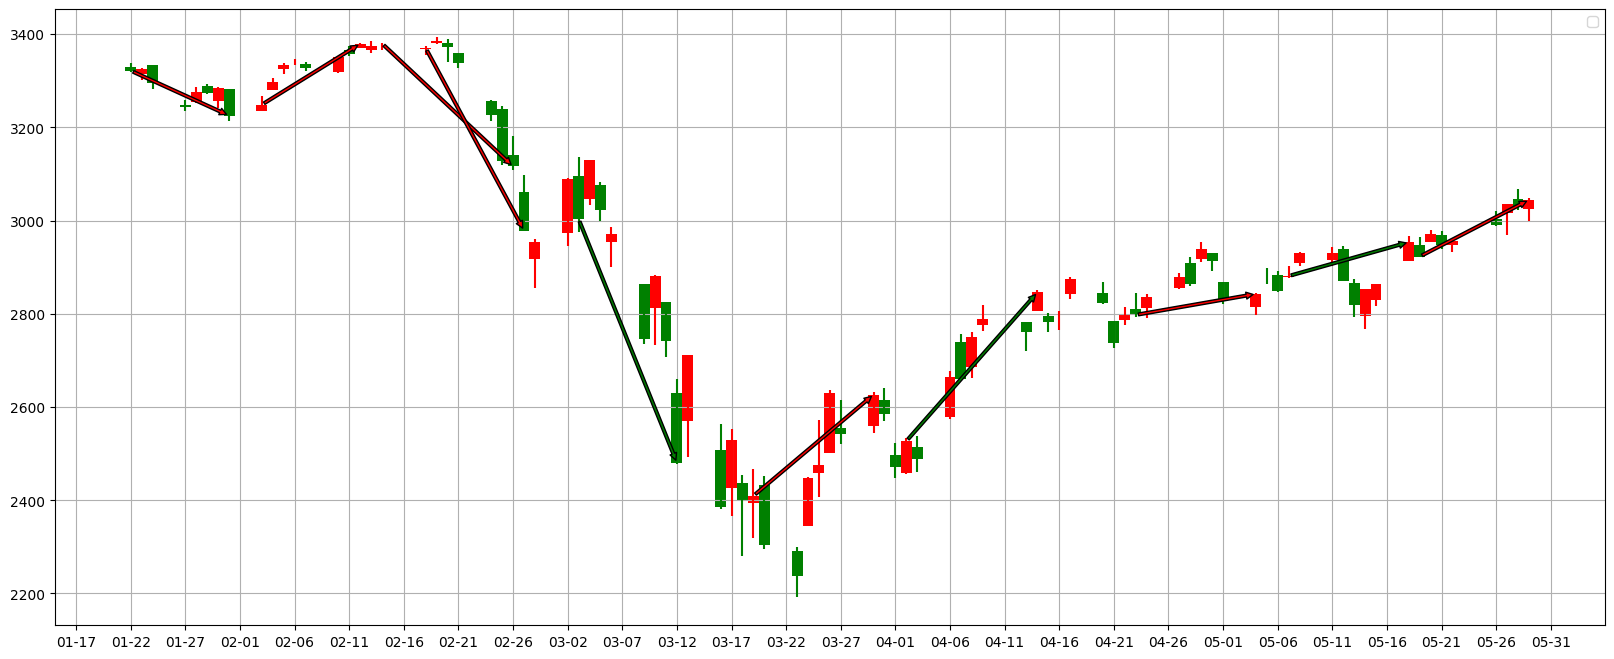

In [43]:
draw_profit_plot(profit_table, pv_range)

In [44]:
def build_profit_table_method_2(result_table, profit_percentage, loss_percentage):
    '''percentage:fioat
    '''
    profit_table = pd.DataFrame(columns=['in_date', 'in_price', 'out_date', 'out_price', 'pv', 'profit', 'strategy', 'strategy_price'])
    total_profit = 0
    for i in result_table.index:
        in_price = all_data['Close'].iloc[all_data.index.get_loc(result_table.loc[i, 't_date'])]
        if result_table.loc[i, 'pv'] == 'valley':
            stop_profit_price = in_price*(1+profit_percentage)
            stop_loss_price = in_price*(1-loss_percentage)
        else:
            stop_profit_price = in_price*(1-profit_percentage)
            stop_loss_price = in_price*(1+loss_percentage)

        # print(in_price, stop_loss_price, stop_profit_price)
        start_index = all_data.index.get_loc(result_table.loc[i, 't_date'])
        end_index = all_data.index.get_loc(result_table.loc[i, 't_date'])+pv_range
        trade_data = all_data.iloc[start_index:end_index]
        # check out_price
        out_price = all_data['Close'].iloc[end_index]
        profit_table.loc[i, 'out_date'] = all_data.iloc[end_index].name
        for j in trade_data.index[1:]:
            high = trade_data['High'].loc[j]
            low = trade_data['Low'].loc[j]
            if result_table.loc[i, 'pv'] == 'valley':
                if high>=stop_profit_price:
                    out_price = stop_profit_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_profit'
                    profit_table.loc[i, 'strategy_price'] = stop_profit_price
                    break
                elif low<=stop_loss_price:
                    out_price = stop_loss_price
                    profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                    profit_table.loc[i, 'strategy'] = 'stop_loss'
                    profit_table.loc[i, 'strategy_price'] = stop_loss_price
                    break
            elif result_table.loc[i, 'pv'] == 'peak':
                    if low<=stop_profit_price:
                        out_price = stop_profit_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_profit'
                        profit_table.loc[i, 'strategy_price'] = stop_profit_price
                        break
                    elif high>=stop_loss_price:
                        out_price = stop_loss_price
                        profit_table.loc[i, 'out_date'] = trade_data.loc[j].name
                        profit_table.loc[i, 'strategy'] = 'stop_loss'
                        profit_table.loc[i, 'strategy_price'] = stop_loss_price
                        break

        if result_table.loc[i, 'pv'] == 'valley':
            profit = out_price - in_price
            profit_table.loc[i, 'pv'] = 'valley'
        else:
            profit = in_price - out_price
            profit_table.loc[i, 'pv'] = 'peak'
        profit_table.loc[i, 'in_date'] = result_table.loc[i, 't_date']
        profit_table.loc[i, 'in_price'] = in_price
        
        profit_table.loc[i, 'out_price'] = out_price
        profit_table.loc[i, 'profit'] = profit
        total_profit += profit
    return total_profit, profit_table

In [45]:
total_profit, profit_table = build_profit_table_method_2(result_table, profit_percentage, loss_percentage)


In [46]:
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(profit_table)

total_profit = -40.10966796875027
           in_date in_price    out_date out_price      pv  profit   strategy  \
data_0  2020-01-22  3321.75  2020-01-31   3225.52  valley  -96.23        NaN   
data_1  2020-02-03  3248.92  2020-02-12   3379.45  valley  130.53        NaN   
data_2  2020-02-14  3380.16  2020-02-26   3116.39  valley -263.77        NaN   
data_3  2020-02-18  3370.29  2020-02-27   2978.76  valley -391.53        NaN   
data_4  2020-03-03  3003.37  2020-03-12   2480.64    peak  522.73        NaN   
data_5  2020-03-19  2409.39  2020-03-30   2626.65  valley  217.26        NaN   
data_6  2020-04-02   2526.9  2020-04-09   2779.59    peak -252.69  stop_loss   
data_7  2020-04-23   2797.8  2020-05-04   2842.74  valley   44.94        NaN   
data_8  2020-05-07  2881.19  2020-05-18   2953.91    peak  -72.72        NaN   
data_9  2020-05-19  2922.94  2020-05-29   3044.31  valley  121.37        NaN   

       strategy_price  
data_0            NaN  
data_1            NaN  
data_2       

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


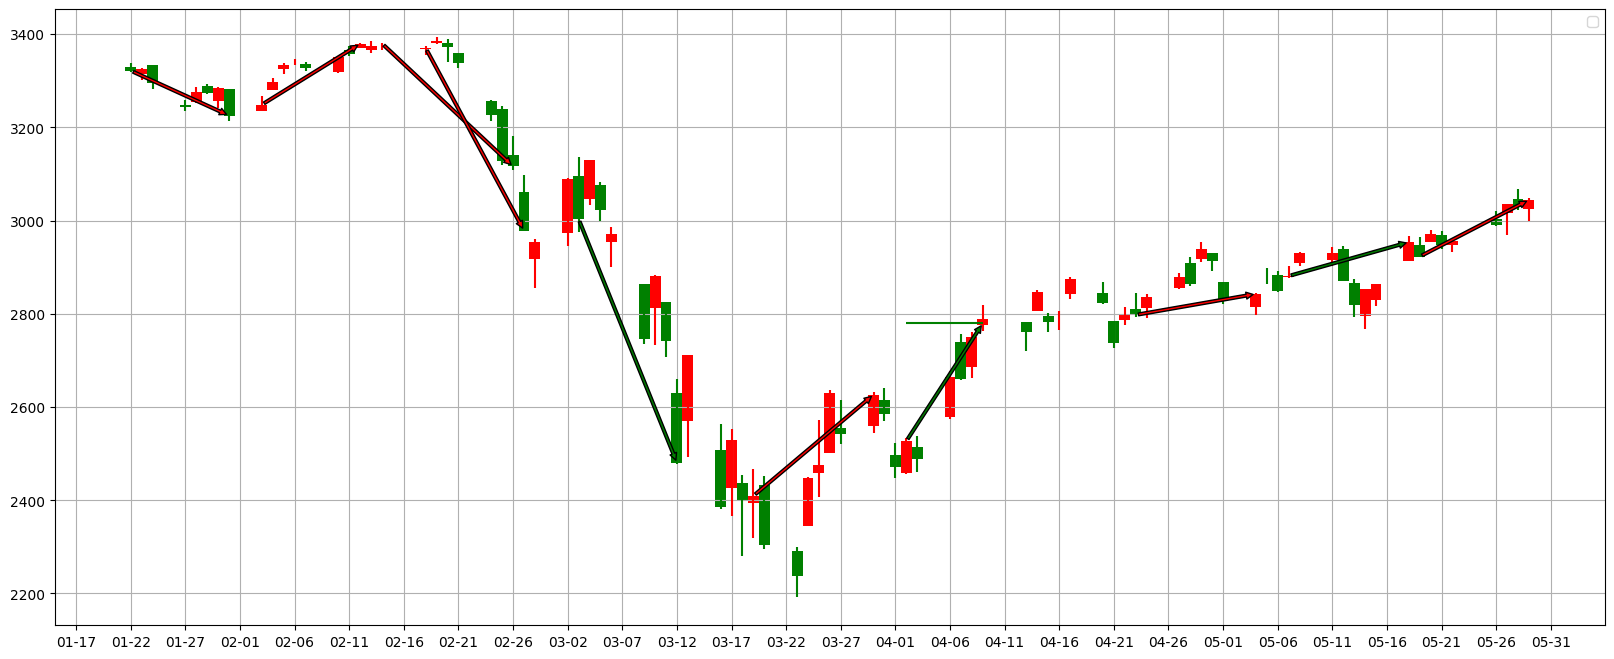

In [47]:
draw_profit_plot(profit_table, pv_range)